**Por Gabriel Garcia Caysahuana**

**Definición de variables:**

- default: Un factor con niveles e indicando si el cliente incumplió con el pago de su deuda {No Yes)

- student: Un factor con niveles e indicando si el cliente es un estudiante {No Yes}

- balance: El saldo medio que el cliente le queda en su tarjeta de crédito después de hacer su pago mensual

- income: Ingresos del cliente

### *Indice del trabajo*

- [Predicción de impago](#-Exámen-Parcial)
  - [Preprocesamiento](#-Preprocesamiento)
  
    - [1. Cargar archivo](#1.-Cargar-archivo)
    
    - [2. Analisis exploratorio de datos](#2.-Analisis-exploratorio-de-datos)
          - [2.1. Características de las variables](#2.1.-Características-de-las-variables)
          - [2.2. Valores únicos (V. categóricas)](#2.2.-Valores-únicos-(V.-categóricas))         
          - [2.3. Estadísticos descriptivos](#2.3.-Estadísticos-descriptivos)
          - [2.4. Análisis gráfico](#2.4.-Análisis-gráfico)
              - [2.4.1. Univariado](#2.4.1.-Univariado)
              - [2.4.2. Multivariado](#2.4.2.-Multivariado)
        
    - [3. Transformaciones](#3.-Transformaciones)
          - [3.1. Agregación y transformación de Box Cox](#3.1.-Agregación-y-transformación-de-Box-Cox)
          
  - [Modelamiento](#-Modelamiento) 
  
    - [1. Regresión Logística](#1.-Regresión-Logística)
    
    - [2. Arbol de Desición](#2.-Arbol-de-Desición)      
    - [3. Gaussian Bayes Naives](#3.-Gaussian-Bayes-Naives)     
    - [4. Comparación de modelos](#4.-Comparación-de-modelos)     

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
import statsmodels.api as srm
from imblearn.over_sampling import SMOTE
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from imblearn.pipeline import Pipeline
#para graficar el arbol de decision
from io import StringIO
from IPython.display import Image
from pydot import graph_from_dot_data
from sklearn.naive_bayes import GaussianNB

In [3]:
import os
os.environ["PATH"] += os.pathsep + r'C:\Users\PC SITOS\AppData\Roaming\Python\Python39\site-packages\graphviz\bin'

# Exámen Parcial

## Preprocesamiento

### 1. Cargar archivo

In [4]:
df = pd.read_csv('Default.csv')
df.shape

(10000, 4)

### 2. Analisis exploratorio de datos

#### 2.1. Características de las variables

In [5]:
df.isnull().sum()

default    0
student    0
balance    0
income     0
dtype: int64

In [6]:
df.dtypes

default     object
student     object
balance    float64
income     float64
dtype: object

#### 2.2. Valores únicos (V. categóricas)

In [7]:
df['default'].unique()

array(['No', 'Yes'], dtype=object)

#### 2.3. Estadísticos descriptivos

In [8]:
df.describe(include = 'O').round(2).T

,count,unique,top,freq
default,10000,2,No,9667
student,10000,2,No,7056


In [9]:
df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
balance,10000.0,835.37,483.71,0.00,481.73,823.64,1166.31,2654.32
income,10000.0,33516.98,13336.64,771.97,21340.46,34552.64,43807.73,73554.23


#### 2.4. Análisis gráfico

##### 2.4.1. Univariado

In [14]:
sns.set_style("whitegrid")

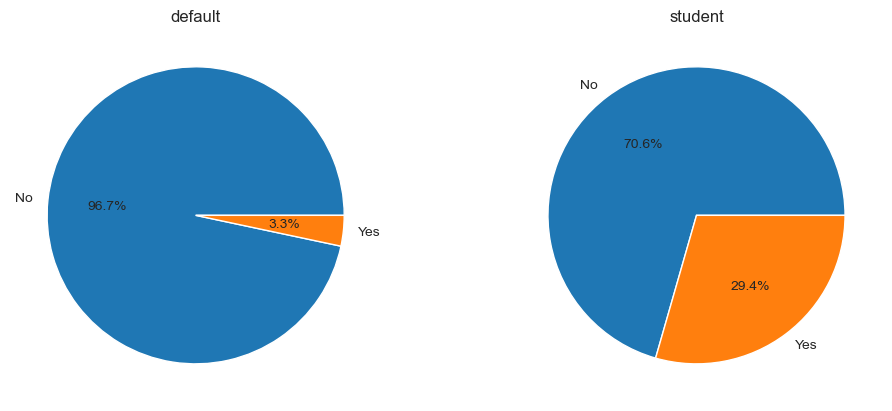

In [15]:
count_default = df['default'].value_counts()
count_student = df['student'].value_counts()
fig, axs = plt.subplots(1,2, figsize=(10,4), layout = 'constrained')
axs[0].pie(count_default, labels = count_default.index, autopct = '%1.1f%%')
axs[1].pie(count_student,labels = count_student.index, autopct = '%1.1f%%')
axs[0].set_title('default')
axs[1].set_title('student')
plt.show()

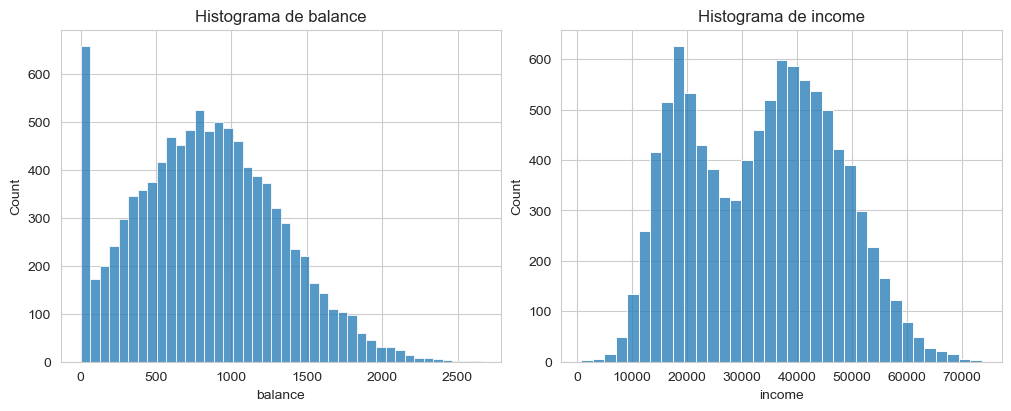

In [16]:
fig, axs = plt.subplots(1,2, figsize=(10,4), layout = 'constrained')
sns.histplot(data = df, x = 'balance', ax = axs[0])
sns.histplot(data = df, x = 'income', ax = axs[1])
axs[0].set_title('Histograma de balance')
axs[1].set_title('Histograma de income')
plt.show()

##### 2.4.1. Multivariado

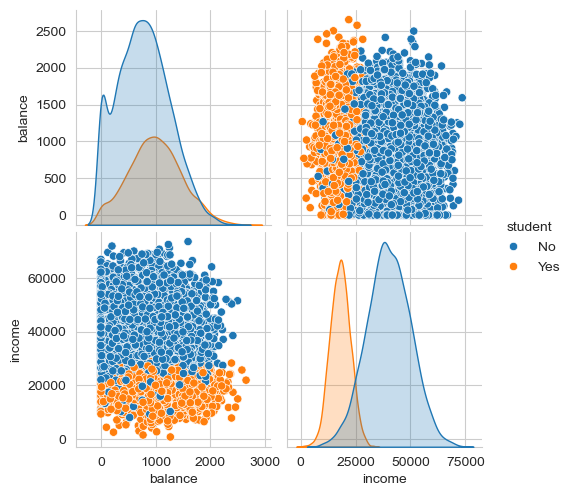

In [17]:
sns.pairplot(data = df, hue = 'student')

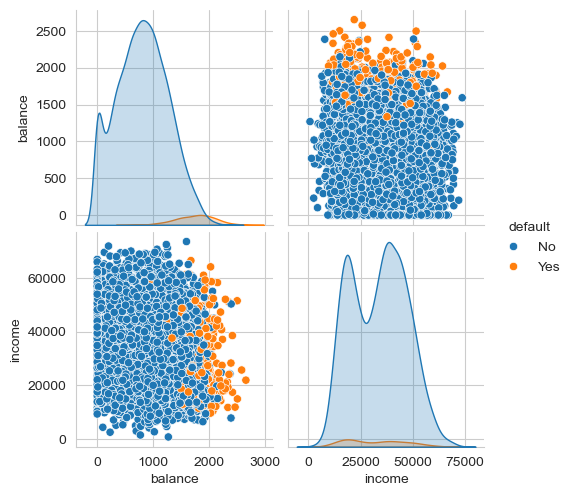

In [18]:
sns.pairplot(data = df, hue = 'default')

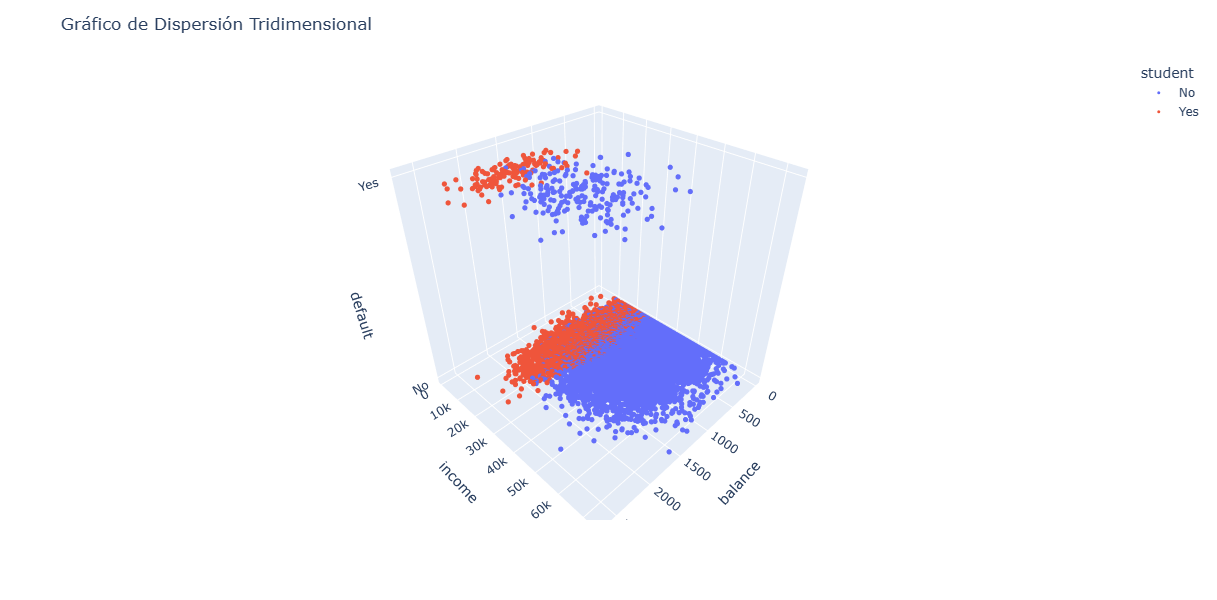

In [22]:
import plotly.express as px

fig = px.scatter_3d(df, x='balance', y='income', z='default', color ='student', color_continuous_scale='viridis')
fig.update_layout(width=800, height=600)
fig.update_traces(marker=dict(size=3)) 
fig.update_layout(title='Gráfico de Dispersión Tridimensional', scene=dict(xaxis_title='balance', yaxis_title='income', zaxis_title='default'))
fig.show()

### 3. Transformaciones

#### 3.1. Agregación y transformación de Box Cox

In [23]:
#Asignación de dumnies a categorías
df['default'] = df['default'].apply(lambda x:1 if x == 'Yes' else 0)
df['student'] = df['student'].apply(lambda x:1 if x == 'Yes' else 0)

In [24]:
#Transformación de Box Cox
df['ln_balance'] = np.log(df['balance']+1)
df['ln_income'] = np.log(df['income']+1)

In [25]:
#Interacción de variables
df['ln_balance_ln_income'] = df['ln_balance']*df['ln_income']
df['ln_balance_student'] = df['ln_balance']*df['student']
df['ln_income_student'] = df['ln_income']*df['student']

## Modelamiento

#### 1. Regresión Logística

In [26]:
#Vamos a separar las variables independientes y la variable dependiente
# se condidera en el modelo las siguientes variables de interacción 'ln_balance_student' y 'ln_income_student' aunque su efecto sea mínimo.
x_cols = ['ln_balance','student','ln_income','ln_balance_ln_income','ln_balance_student','ln_income_student'] 
X = df[x_cols] 
y = df['default'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.30)

In [27]:
y_train.value_counts()

default
0    6761
1     239
Name: count, dtype: int64

In [28]:
# se realiza el remuestreo debido a que la muestra esta desequilibridada en la variable 'default'
sm = SMOTE(sampling_strategy='auto', random_state=42)
X_train_n, y_train_n = sm.fit_resample(X_train, y_train) 

In [29]:
y_train_n.value_counts()

default
0    6761
1    6761
Name: count, dtype: int64

In [30]:
X_train_n = pd.DataFrame(X_train_n, columns = X.columns)
X_test = pd.DataFrame(X_test, columns = X.columns)

In [31]:
logit_model=srm.Logit(y_train_n, srm.add_constant(X_train_n))
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.264282
         Iterations 11
                             Results: Logit
Model:                 Logit               Pseudo R-squared:    0.619    
Dependent Variable:    default             AIC:                 7161.2552
Date:                  2023-10-20 18:27    BIC:                 7213.8397
No. Observations:      13522               Log-Likelihood:      -3573.6  
Df Model:              6                   LL-Null:             -9372.7  
Df Residuals:          13515               LLR p-value:         0.0000   
Converged:             1.0000              Scale:               1.0000   
No. Iterations:        11.0000                                           
-------------------------------------------------------------------------
                       Coef.   Std.Err.    z    P>|z|    [0.025   0.975] 
-------------------------------------------------------------------------
const                -162.4069  43.1255

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\iolib\summary2.py:579: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



In [41]:
reg_log = LogisticRegression(random_state = 42)

reg_log.fit(X_train_n, y_train_n)

y_pred_logit = reg_log.predict(X_test)

m = metrics.confusion_matrix(y_test, y_pred_logit)

In [37]:
sns.set_style('white')

Text(0.5, 1.0, 'Matriz de confusión - regresión logística')

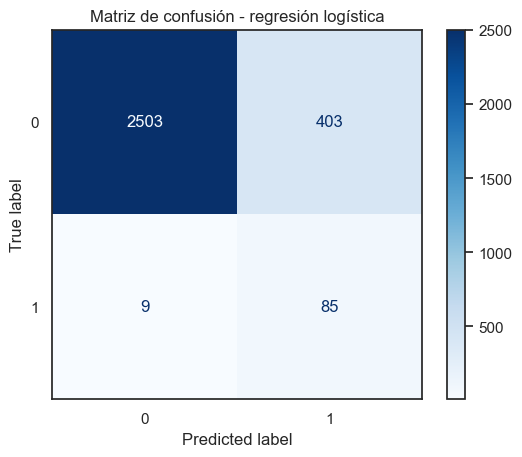

In [42]:
disp = ConfusionMatrixDisplay(confusion_matrix=m)
disp.plot(cmap='Blues')
plt.title('Matriz de confusión - regresión logística')

In [43]:
#Indicadores de la matriz de confusión
target_names = ['No incumple con el pago', 'Imcumple con el pago']
metricas_logit = classification_report(y_test, y_pred_logit, target_names=target_names)
print(metricas_logit)

                         precision    recall  f1-score   support

No incumple con el pago       1.00      0.86      0.92      2906
   Imcumple con el pago       0.17      0.90      0.29        94

               accuracy                           0.86      3000
              macro avg       0.59      0.88      0.61      3000
           weighted avg       0.97      0.86      0.90      3000



Se observa una presisición de uno, para las predicciones de valor cero de la variable default, la formula viene dada por 2503 /(2503+9) = 0.99641719745.

In [44]:
#Curva ROC
y_pred_proba = reg_log.predict_proba(X_test)[::,1]
fpr_logi, tpr_logi, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc_logi = metrics.roc_auc_score(y_test, y_pred_proba)
# plt.figure(figsize = (5,4))
# plt.plot(fpr_logi, tpr_logi, label="data1,auc="+str(auc_logi))
# plt.legend(loc=4)
# plt.show()

#### 2. Arbol de Desición

In [45]:
x_cols = ['ln_balance','student','ln_income'] 
X = df[x_cols] 
y = df['default'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.30)

In [50]:
max_leaf_nodes = [5,10,20,25] #Número máximo de nodos "hoja" en el modelo
max_depth = [3,4] #Profundidad máxima del arbol
parametros = dict(tree__max_leaf_nodes = max_leaf_nodes,
             tree__max_depth=max_depth)
model_tree = Pipeline(steps=[
        ('sampling', SMOTE()),
        ('tree', DecisionTreeClassifier(criterion = 'entropy'))
    ])
tree_cv=GridSearchCV(model_tree,parametros,cv=10)
tree_cv.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('sampling', SMOTE()),
                                       ('tree',
                                        DecisionTreeClassifier(criterion='entropy'))]),
             param_grid={'tree__max_depth': [3, 4],
                         'tree__max_leaf_nodes': [5, 10, 20, 25]})

In [51]:
print('Best params:')
print(tree_cv.best_params_)

Best params:
{'tree__max_depth': 4, 'tree__max_leaf_nodes': 20}


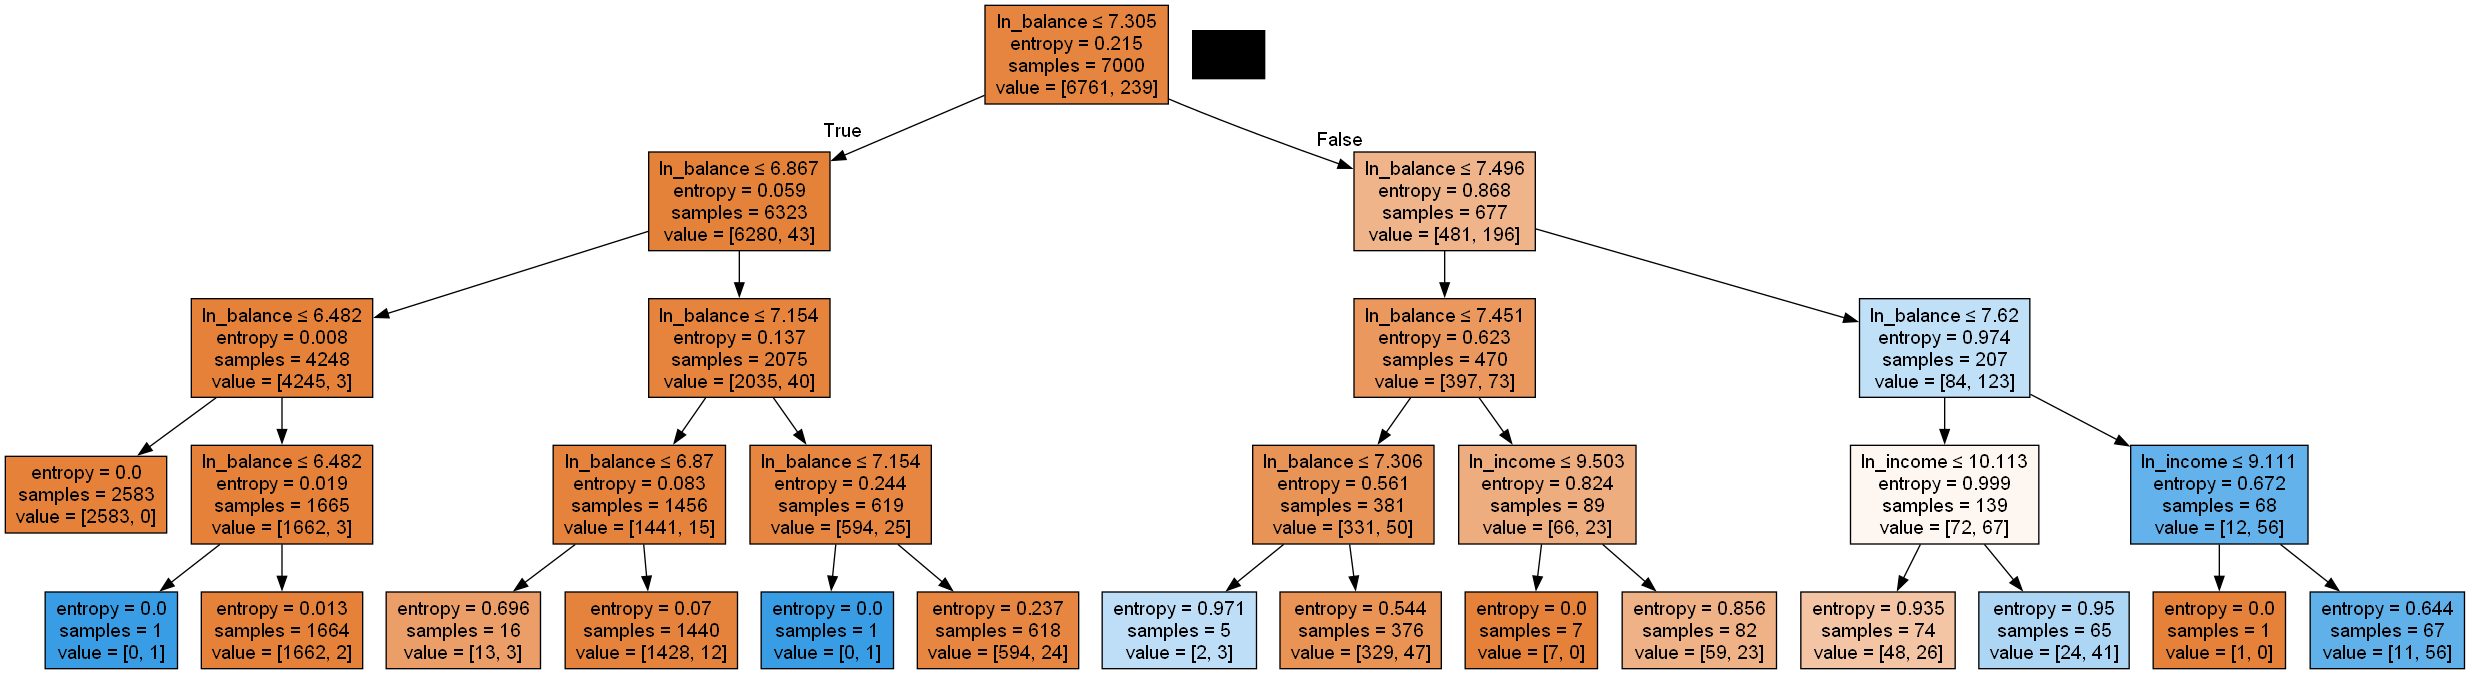

In [52]:
arbol = DecisionTreeClassifier(criterion = 'entropy',max_depth= 4, max_leaf_nodes= 25)
arbol.fit(X_train, y_train)
#Con esta función se grafica mas grande y es mas facil de leer
dot_data = StringIO()
export_graphviz(arbol, out_file=dot_data, feature_names=X_train.columns,filled= True,                
               special_characters=True)
(graph, ) = graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [53]:
arbol = tree_cv.best_estimator_

Text(0.5, 1.0, 'Matriz de confusión - arbol de desición')

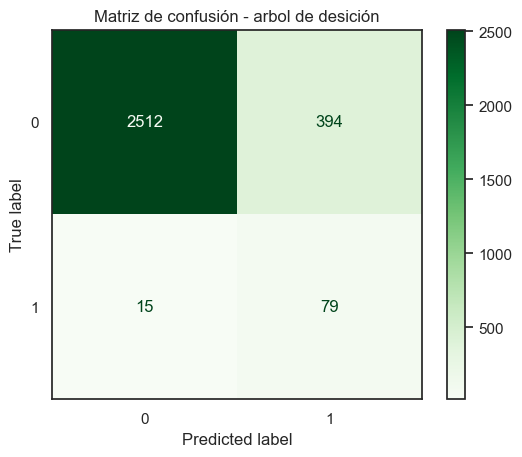

In [54]:
#matriz de confusión
y_pred_tree = arbol.predict(X_test)
cm = confusion_matrix(y_test, y_pred_tree)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Greens')
plt.title('Matriz de confusión - arbol de desición')

In [55]:
#Indicadores de la matriz de confusión
target_names = ['No incumple con el pago', 'Imcumple con el pago']
metricas_tree = classification_report(y_test, y_pred_tree, target_names=target_names)
print(metricas_tree)

                         precision    recall  f1-score   support

No incumple con el pago       0.99      0.86      0.92      2906
   Imcumple con el pago       0.17      0.84      0.28        94

               accuracy                           0.86      3000
              macro avg       0.58      0.85      0.60      3000
           weighted avg       0.97      0.86      0.90      3000



In [56]:
#Curva ROC del arbol de desicion
fpr_tree, tpr_tree, _ = roc_curve(y_test, arbol.predict_proba(X_test)[::,1])
auc_tree = roc_auc_score(y_test, y_pred_tree)
# plt.figure(figsize = (5,4))
# plt.plot(fpr_tree, tpr_tree, label="tree,auc="+str(auc_tree))
# plt.legend(loc=4)
# plt.show()

#### 3. Gaussian Bayes Naives

In [57]:
# se condidera en el modelo las siguientes variables de interacción 'ln_balance_student' y 'ln_income_student' aunque su efecto sea mínimo.

In [58]:
x_cols = ['ln_balance','student','ln_income','ln_balance_ln_income','ln_balance_student', 'ln_income_student'] 
X = df[x_cols] 
y = df['default'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.30)

sm = SMOTE(sampling_strategy='auto', random_state=42)
X_train_n, y_train_n = sm.fit_resample(X_train, y_train) 

X_train_n = pd.DataFrame(X_train_n, columns = X.columns)
X_test = pd.DataFrame(X_test, columns = X.columns)

In [59]:
gaussian = GaussianNB()
gaussian.fit(X_train_n, y_train_n)
y_pred_gaussian = gaussian.predict(X_test)

Text(0.5, 1.0, 'Matriz de confusión - Gaussian Naive bayes')

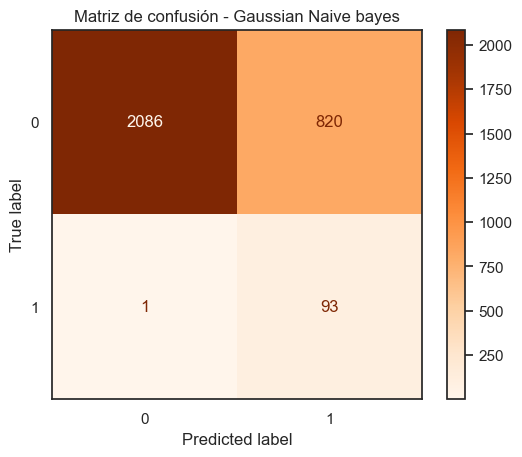

In [60]:
#matriz de confusión
cm = confusion_matrix(y_test, y_pred_gaussian)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Oranges')
plt.title('Matriz de confusión - Gaussian Naive bayes')

In [61]:
#Indicadores de la matriz de confusión
target_names = ['No incumple con el pago', 'Imcumple con el pago']
metricas_gaussian = classification_report(y_test, y_pred_gaussian, target_names=target_names)
print(metricas_gaussian)

                         precision    recall  f1-score   support

No incumple con el pago       1.00      0.72      0.84      2906
   Imcumple con el pago       0.10      0.99      0.18        94

               accuracy                           0.73      3000
              macro avg       0.55      0.85      0.51      3000
           weighted avg       0.97      0.73      0.82      3000



In [62]:
#Curva ROC
y_pred_proba = gaussian.predict_proba(X_test)[::,1]
fpr_gaussian, tpr_gaussian, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc_gaussian = metrics.roc_auc_score(y_test, y_pred_proba)
# plt.figure(figsize = (5,4))
# plt.plot(fpr_naive, tpr_naive, label="data1,auc="+str(auc_naive))
# plt.legend(loc=4)
# plt.show()

#### 4. Comparación de modelos

In [63]:
# Crear un DataFrame para el cuadro comparativo
print('Logistic Regression:')
print(metricas_logit)
print('Decision Tree:')
print(metricas_tree)
print('Gaussian Naive Bayes:')
print(metricas_gaussian)

Logistic Regression:
                         precision    recall  f1-score   support

No incumple con el pago       1.00      0.86      0.92      2906
   Imcumple con el pago       0.17      0.90      0.29        94

               accuracy                           0.86      3000
              macro avg       0.59      0.88      0.61      3000
           weighted avg       0.97      0.86      0.90      3000

Decision Tree:
                         precision    recall  f1-score   support

No incumple con el pago       0.99      0.86      0.92      2906
   Imcumple con el pago       0.17      0.84      0.28        94

               accuracy                           0.86      3000
              macro avg       0.58      0.85      0.60      3000
           weighted avg       0.97      0.86      0.90      3000

Gaussian Naive Bayes:
                         precision    recall  f1-score   support

No incumple con el pago       1.00      0.72      0.84      2906
   Imcumple con el pago  

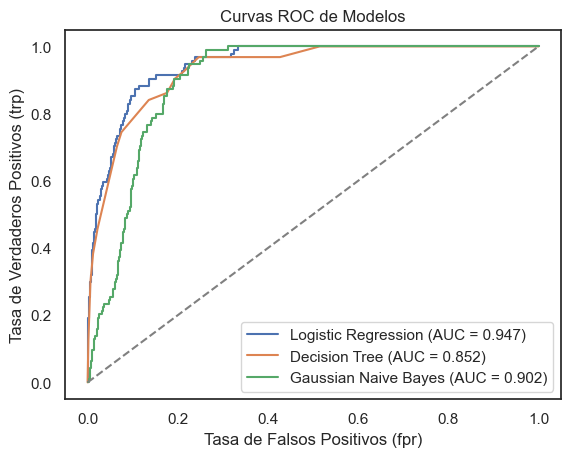

In [65]:
plt.plot(fpr_logi, tpr_logi, label=f'Logistic Regression (AUC = {auc_logi:.3f})')

plt.plot(fpr_tree, tpr_tree, label=f'Decision Tree (AUC = {auc_tree:.3f})' )

plt.plot(fpr_gaussian, tpr_gaussian, label=f'Gaussian Naive Bayes (AUC = {auc_gaussian:.3f})')


plt.plot([0,1], [0,1], color='gray', linestyle='--')

plt.xlabel('Tasa de Falsos Positivos (fpr)')
plt.ylabel('Tasa de Verdaderos Positivos (trp)')
plt.title('Curvas ROC de Modelos')
plt.legend()

plt.show()